Exploratory Data Analysis on the patient demographics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv")
print(data[:10])

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker
9  ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker


Outline of what each columns represent:  
Patient(str): unique ID for each patient  
Weeks(int): the relative number of weeks pre/post the baseline CT scan  
FVC(int): the recorded lung capacity in ml  
Percent(float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics  
Age(int), Sex(str), SmokingStatus(str)

First, the rows are grouped by weeks, to attempt to identify trends in change in FVC and Percent over time.

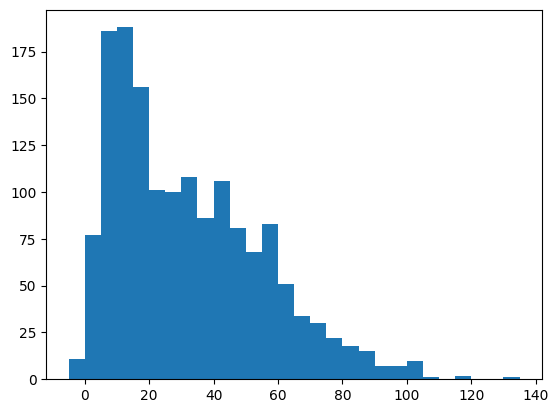

In [4]:
bin_width = 5
bins = np.arange(min(data["Weeks"]), max(data["Weeks"]) + bin_width, bin_width)

weeks_dist = plt.hist(data["Weeks"], bins=bins)

For now, FVC readings measured pre-CT scans are dropped, then readings are grouped by Weeks, at a 5-week interval.

In [ ]:
post_CT_data = data[data["Weeks"]>=0]
